## Predictive Modeling: Using Random Forest

In [243]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
print(os.listdir("../input"))

['updating-testing-data', 'exploratory-analysis', 'rossmann-store-sales']


In [244]:
training = pd.read_csv("../input/exploratory-analysis/training.csv")
testing = pd.read_csv("../input/updating-testing-data/testing.csv")
test = pd.read_csv("../input/rossmann-store-sales/test.csv")

#### Split training data for testing within kernel
Since testing data ranges on stores from 2015-08-01 to 2015-09-17, which is 47 days (about 6-7 weeks), I will take the last 6 weeks of data for validation.

In [245]:
training['Date'] = pd.to_datetime(training['Date'])
testing['Date'] = pd.to_datetime(testing['Date'])
training = training.sort_values(['Date'],ascending = False)
training_total = training # ALL values, used for final testing and submission
testing_total = testing

split_index = 6*7*1115 # calculating number of rows, 6 weeks, 7 days per week, 1115 stores

valid_within = training[:split_index] # use this for testing within kernel
train_within = training[split_index:] # use this for training within kernel



### Fixing Training & Testing data
This includes label encoding categorical variables and adding a couple more numeric variables for better predictions.

In [246]:
# process train and test
import warnings
warnings.filterwarnings('ignore')

def fixing(data, isTest = False):
    # encoding categorical variables
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    # extract some features from date column  
    data['Month_num'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    # competiter open time (in months, days previously calculated)
    data['CompetitionOpenMonths'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month_num - data.CompetitionOpenSinceMonth)
    data['CompetitionOpenMonths'] = data['CompetitionOpenMonths'].apply(lambda x: x if x > 0 else 0)
    
    # calculate promo2 open time in months
    data['PromoOpenMonths'] = 12 * (data.Year - data.Promo2SinceYear) + ((data.WeekOfYear - data.Promo2SinceWeek) / 4.0)
    data['PromoOpenMonths'] = data['PromoOpenMonths'].apply(lambda x: x if x < 100 else 0)
                                                 
    # Check whether the current month is in promo interval
    def check(row):
        if isinstance(row['PromoInterval'],str) and row['Month'] in row['PromoInterval']:
            return 1
        else:
            return 0
        
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1)    
    
    features = ['Store', 'StoreType', 'Assortment', 'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'DayOfWeek', 'Promo', 'isCompOpen', 'Month_num','Year', 'Day', 'WeekOfYear', 'PromoOpenMonths', 'CompetitionOpenMonths', 'IsPromoMonth']

    if not isTest:
        features.append('Sales') # if not total testing data, add Sales feature

    data = data[features]
    return data


train_within = fixing(train_within)
valid_within = fixing(valid_within)

#final submission testing/training
training_total = fixing(training_total)
testing_total = fixing(testing_total,isTest = True)   

In [247]:
# split features and sales, transform the unit sales with log1p so evaluation metric is the same as rmse with weights,to use built in loss functions 
x_train_within = train_within.drop(columns = ['Sales'])
y_train_within = np.log1p(train_within['Sales'])

x_valid_within = valid_within.drop(columns = ['Sales'])
y_valid_within = np.log1p(valid_within['Sales'])

x_training_total = training_total.drop(columns = ['Sales'])
y_training_total = np.log1p(training_total['Sales'])


### RMSPE, Accuracy (using MAPE)

In [248]:
def rmspe(y_true, y_pred):
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_pred)), axis=0))
    return loss

def accuracy(y_true,y_pred):
    err = abs(y_pred - y_true)
    mape = 100 * (err / y_true)
    accuracy = 100 - np.mean(mape)
    return accuracy

## Random Forest

#### Testing training data within kernel

In [249]:
from sklearn.ensemble import RandomForestRegressor
x_train_within.shape

rf = RandomForestRegressor(n_estimators = 20)
rf.fit(x_train_within, y_train_within)

# validation, RMSPE
y_pred = rf.predict(x_valid_within)
error = rmspe(np.expm1(y_valid_within), np.expm1(y_pred))
print("RMSPE:",error)

# Accuracy
accuracy_score = accuracy(np.expm1(y_valid_within),np.expm1(y_pred))
print('Accuracy:', round(accuracy_score, 2), '%.')

RMSPE: 0.13618679113251403
Accuracy: 89.13 %.


Text(0.5, 1.0, 'Feature Importance')

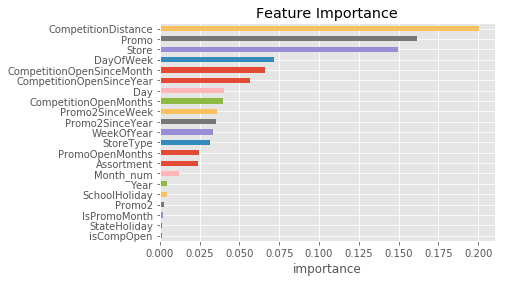

In [250]:
plt.style.use('ggplot')
importances = pd.Series(rf.feature_importances_, index=x_train_within.columns)
importances.sort_values(ascending = True).plot(kind = 'barh')
plt.xlabel('importance')
plt.title('Feature Importance')

My previous exploratory analysis on CompetitionDistance is disproven by the Feature Importance model. I had previously grouped the data into their respective quartile (IQR) distances, and there had shown to be little variation in their average sales. However, as there is such a heavy importance on this feature (show above), I would argue that distance actually does vary a lot depending on distance; perhaps in different ranges than I had chosen.

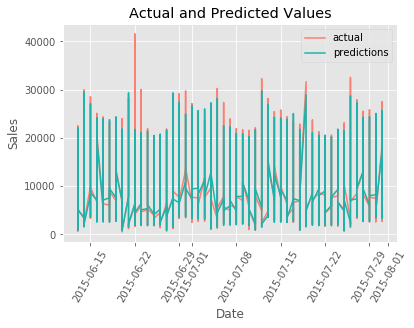

In [251]:
valid_within2 = training[:split_index]

true_data = pd.DataFrame(data = {'date': valid_within2['Date'], 'actual': valid_within2['Sales']})
predictions_data = pd.DataFrame(data = {'date':valid_within2['Date'], 'predictions': np.expm1(y_pred)})

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', color = 'salmon')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['predictions'], 'r', label = 'predictions', color = 'lightseagreen')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Actual and Predicted Values');


### Running Predictions for Submission

In [252]:
rf2 = RandomForestRegressor(n_estimators = 20)
rf2.fit(x_training_total, y_training_total)

# validation, RMSPE
y_pred_total = rf2.predict(testing_total)

In [253]:
submission = pd.DataFrame({"Id": testing["Id"],'Sales': np.expm1(y_pred_total)})
submission.to_csv("submission.csv", index=False)

### Public Score RMSPE: 0.13295
### Private Score RMSPE: 0.15334